# Attention

NB: Puisque le projet se fait sur Google Colab, nous devons utiliser Drive pour stocker les fichiers de façon durable.

Si vous exécuter le code localement, vous n'avez pas besoin de ce bloc de code. Il faudra penser à mettre à jour la variable root_path deux blocs plus loin.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Lecture et analyse globale

Dès la lecture, nous allons séparer le jeu de données que nous avons reçu (le "train") en deux jeux, train et eval. Nous ferons nos analyses, visualisations et modélisations sur le jeu de train. Nous utiliserons le jeu eval pour évaluer nos modèles et nos approches avant l'application sur le jeu de test.

In [ ]:
# On s'assure que vous avez exactement les mêmes versions que les librairies utilisées dans ce notebook
!pip install -q pandas==2.2.2 scikit-learn==1.5.2 matplotlib==3.8.0 numpy==1.26.4 tqdm==4.66.6 imbalanced-learn==0.12.4 shap==0.46.0 equipy==0.0.6a0.dev0

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

random_state=24

root_path = "/content/drive/My Drive/Projet CNAM"
path_train = f"{root_path}/train_11.csv"
path_test = f"{root_path}/test.csv"

df_init = pd.read_csv(path_train, sep=";")

df_train, df_eval = train_test_split(df_init, test_size=0.1, stratify=df_init.interesse,
                                     random_state=random_state)
df_train = df_train.reset_index(drop=True)
df_eval = df_eval.reset_index(drop=True)
df_test = pd.read_csv(path_test, sep=",")
df_train.shape, df_eval.shape, df_test.shape

((45000, 12), (5000, 12), (30000, 11))

**Descriptif**

Variable | Définition
--- | ---
genre | Genre de l’assuré
age | Age de l’assuré
permisConduire  | 0 : l’assuré n’a pas de permis de conduire
 | 1 : l’assuré a un permis de conduire
codeRegion | Code anonymisé de la region de l’assuré
dejaAssure | 1 : l’assuré a déjà une assurance auto
 | 0 : l’assuré n’a pas encore d’assurance auto
ageVehicule |  Age du véhicule
accidentVehicule |  1 : l’assuré a déjà eu un sinistre automobile
 | 0 : l’assuré n’a jamais eu de sinistre automobile
primeAnnuelle |  La valeur de la prime annuelle proposée
canalDistribution |  Code du canal de communication avec l’assuré e.g. agents d’assurance, email, téléphone, en personne, etc.
tempsAssure  | Nombre de jours depuis que l’assuré a un contrat avec la compagnie
interesse  | 1 : l’assuré est intéressé
 | 0 : l’assuré n’est pas intéressé

## Valeurs manquantes

In [ ]:
pd.concat([df_train.isna().mean(), df_eval.isna().mean(), df_test.isna().mean()], axis=1, keys=["train","eval", "test"])

# pas de valeurs manquantes

,train,eval,test
id,0.0,0.0,0.0
genre,0.0,0.0,0.0
age,0.0,0.0,0.0
permisConduire,0.0,0.0,0.0
codeRegion,0.0,0.0,0.0
dejaAssure,0.0,0.0,0.0
ageVehicule,0.0,0.0,0.0
accidentVehicule,0.0,0.0,0.0
primeAnnuelle,0.0,0.0,0.0
canalDistribution,0.0,0.0,0.0


### Conclusion

Pas de valeurs manquantes. Pas besoin de traitement particulier

(la valeur cible est absente du jeu de test)

## Types et description

In [ ]:
print(df_train.info())
df_train.describe().transpose()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 45000 non-null  int64 
 1   genre              45000 non-null  object
 2   age                45000 non-null  int64 
 3   permisConduire     45000 non-null  int64 
 4   codeRegion         45000 non-null  int64 
 5   dejaAssure         45000 non-null  int64 
 6   ageVehicule        45000 non-null  object
 7   accidentVehicule   45000 non-null  object
 8   primeAnnuelle      45000 non-null  int64 
 9   canalDistribution  45000 non-null  int64 
 10  tempsAssure        45000 non-null  int64 
 11  interesse          45000 non-null  int64 
dtypes: int64(9), object(3)
memory usage: 4.1+ MB
None


,count,mean,std,min,25%,50%,75%,max
id,45000.0,25025.219178,14433.722749,1.0,12574.75,25037.5,37521.25,50000.0
age,45000.0,42.198911,17.980591,20.0,27.00,40.0,51.00,140.0
permisConduire,45000.0,0.824222,0.380635,0.0,1.00,1.0,1.00,1.0
codeRegion,45000.0,26.675178,13.065360,0.0,15.00,28.0,35.00,52.0
dejaAssure,45000.0,0.300533,0.458495,0.0,0.00,0.0,1.00,1.0
primeAnnuelle,45000.0,144742.841667,625778.836604,2630.0,23945.75,31354.0,38454.00,4991600.0
canalDistribution,45000.0,107.349511,55.018136,1.0,26.00,124.0,152.00,163.0
tempsAssure,45000.0,223.594378,423.734373,10.0,85.00,161.0,237.00,5586.0
interesse,45000.0,0.247889,0.431792,0.0,0.00,0.0,0.00,1.0


### Conclusions

*   Certaines valeurs à priori binaires (genre) sont interprétées comme str par Python, indiquant un besoin de feature engineering là dessus
*   Certaines valeurs à priori quantitatives (ageVehicule) sont interprétées comme str par Python

# Analyse des variables par bloc (qualitative, quantitatives, autres)

In [ ]:
list_quali = ["permisConduire", "dejaAssure", "accidentVehicule", "ageVehicule", "genre"]
list_quanti = ["age", "primeAnnuelle", "tempsAssure"]
list_other = ["codeRegion", "canalDistribution"] # codeRegion et canalDistribution est sont quali, mais nous les traiterons/visualiserons séparément
target = "interesse"

In [ ]:
for var in list_quali+list_other:
    print(f"Nombre de modalités uniques pour {var} : {df_train[var].nunique()}")

Nombre de modalités uniques pour permisConduire : 2
Nombre de modalités uniques pour dejaAssure : 2
Nombre de modalités uniques pour accidentVehicule : 2
Nombre de modalités uniques pour ageVehicule : 3
Nombre de modalités uniques pour genre : 2
Nombre de modalités uniques pour codeRegion : 53
Nombre de modalités uniques pour canalDistribution : 123


### Conclusions

codeRegion et canalDistribution ont trop de modalités. Il faudra les analyser et traiter séparément.

## Variable cible

proportion 0.24788888888888888 de 1 dans le dataset


<Axes: title={'center': 'Proportion clients interesses'}, xlabel='interesse'>

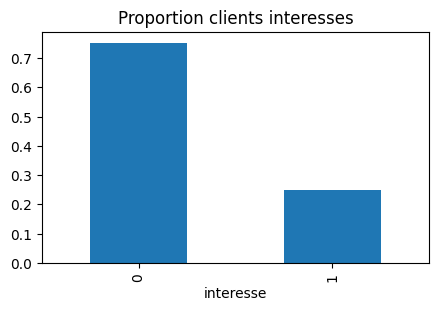

In [ ]:
target_prop=df_train[target].mean()
print(f"proportion {target_prop} de {df_train[target].max()} dans le dataset")
df_train[target].value_counts(normalize=True).plot.bar(title="Proportion clients interesses", figsize=(5, 3))

### Conclusion

La variable cible est déséquilibrée, indiquant un besoin de rééquilibrage par la suite

## Variables qualitatives

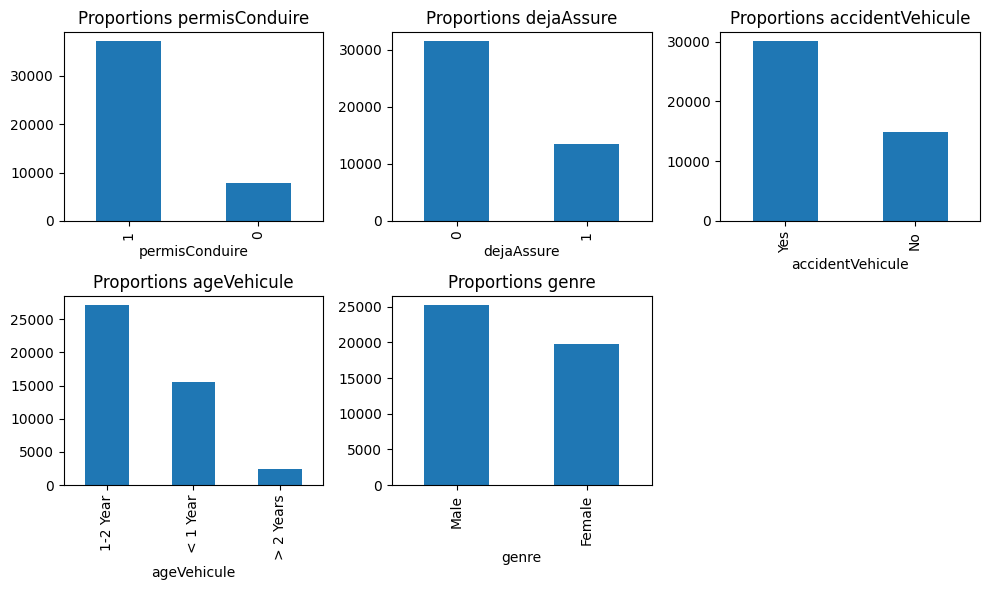

In [ ]:
import matplotlib.pyplot as plt

nrow, ncol = 2, 3
fig, axes = plt.subplots(nrow, ncol, figsize=(10, 6))

# plot counter
count=0
for r in range(nrow):
    for c in range(ncol):
        if count+1<=len(list_quali):
            df_train[list_quali[count]].value_counts().plot.bar(ax=axes[r,c], title=f"Proportions {list_quali[count]}")
            count=count+1
        else:
            axes[r, c].axis("off")

fig.tight_layout()

### Conclusions

*   Nous avons 4 valeurs catégorielles binaires
    *   Deux déjà entières (0 et 1) : permisConduire, dejaAssure
    *   et deux catégorielles textuelles : accidentVehicule, genre
*   et une valeur catégorielle à modalités multiples : ageVehicule



### Variables qualitatives vs variable cible

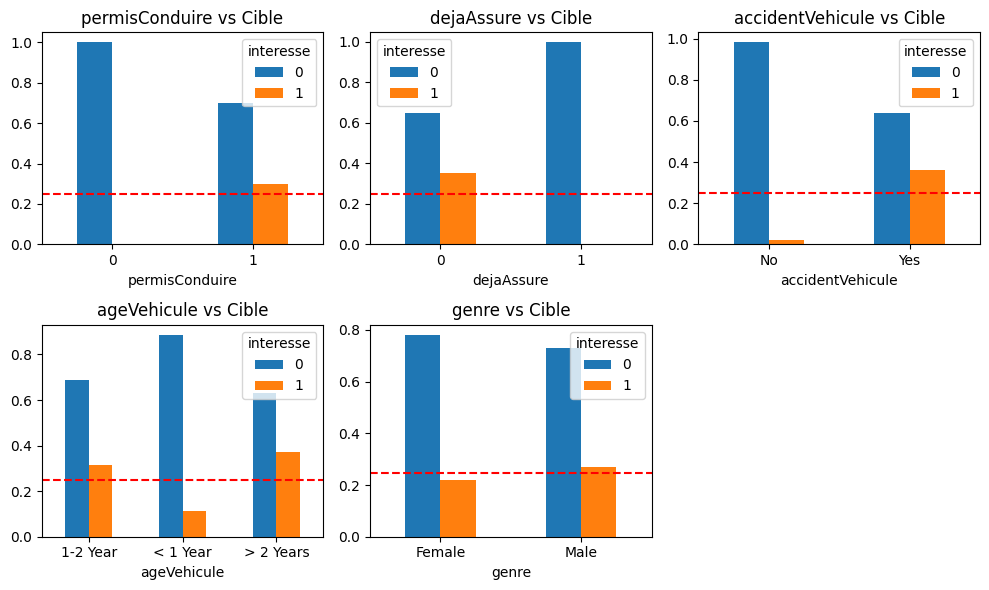

In [ ]:
import matplotlib.pyplot as plt

nrow, ncol = 2, 3
fig, axes = plt.subplots(nrow, ncol, figsize=(10, 6))

# plot counter
count=0
for r in range(nrow):
    for c in range(ncol):
        if count+1<=len(list_quali):
            pd.crosstab(df_train[target], df_train[list_quali[count]], normalize="columns").transpose().plot.bar(ax=axes[r,c],
                                                                                                     title=f"{list_quali[count]} vs Cible",rot=0)
            axes[r,c].axhline(y = target_prop, color = 'r', linestyle = 'dashed')
            count=count+1
        else:
            axes[r, c].axis("off")

fig.tight_layout()

### Conclusion

*   Les clients sans permis ne sont jamais intéressés. Les clients avec permis sont plus intéressés que la moyenne
*   Les clients déjà assurés ne sont jamais assurés. Les clients qui ne le sont pas sont plus intéressés que la moyenne
*   Les clients ayant déjà eu un accident sont plus intéressés que la moyenne. Les clients qui n'ont en pas eu ne sont presque jamais intéressés
*   Les hommes sont plus intéressés que les femmes (de peu)
*   Les clients avec un véhicule plus âgé sont plus intéressés que les clients avec un véhicule neuf



## Pipeline preprocessing quali

*   On convertit nos variables binaires en 0 et 1, avec 1, valant la modalité qui a le plus de chance d'être intresse
*   On convertit notre variable multicatégorielle (ageVehicle) avec la même approche

In [ ]:
def preprocess_quali(df):
    feats_quali=[]
    # on s'occupe d'abord des variables binaires
    # preference : valeur = 1 <=> corrélation positive avec cible
    df["feat_permis"]=(df["permisConduire"]==1).astype(int)
    feats_quali.append("feat_permis")
    df["feat_sans_assurance"]=(df["dejaAssure"]==0).astype(int)
    feats_quali.append("feat_sans_assurance")
    df["feat_accident"]=(df["accidentVehicule"]=="Yes").astype(int)
    feats_quali.append("feat_accident")
    df["feat_homme"]=(df["genre"]=="Male").astype(int)
    feats_quali.append("feat_homme")
    # on traite ensuite la valeur multicatégorielle (ageVehicle)
    df["feat_age_vehicule>1"]=(df.ageVehicule.isin(["1-2 Year", "> 2 Years"])).astype(int)
    feats_quali.append("feat_age_vehicule>1")
    return df, feats_quali

On applique ensuite la pipeline sur le jeu de train et le jeu de test

In [ ]:
list_feat=[]
df_train, feats_quali=preprocess_quali(df_train)
df_eval, _=preprocess_quali(df_eval)
df_test, _=preprocess_quali(df_test)
list_feat.extend(feats_quali)

## Valeurs quantitatives

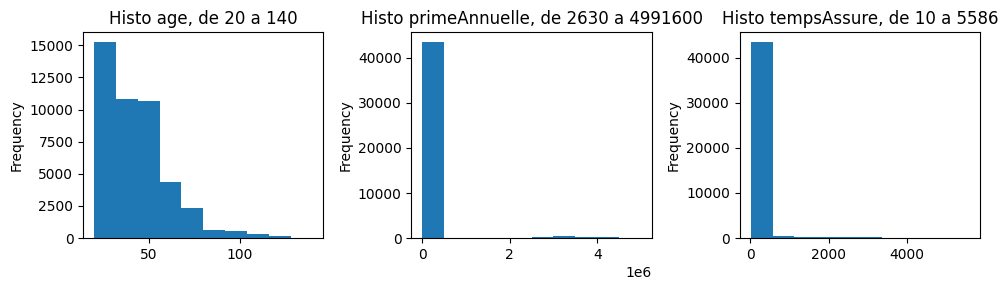

In [ ]:
import matplotlib.pyplot as plt

nrow, ncol = 1, 3
fig, axes = plt.subplots(nrow, ncol, figsize=(10, 3))

# plot counter
count=0
for c in range(ncol):
    df_train[list_quanti[count]].plot.hist(ax=axes[c], title=f"Histo {list_quanti[count]}, de {df_train[list_quanti[count]].min()} a {df_train[list_quanti[count]].max()}")
    count=count+1

fig.tight_layout()

*   D'office, on remarque la différence d'échelle entre les 3 variables
*   Il y a potentiellement des valeurs aberrantes dans les âges (âges supérieurs à 100)
*   Il y a des valeurs extrêmes dans primeAnnuelle et tempsAssure
    *   A priori pas de problème avec les valeurs extrêmes d'un point de vue modélisation, tant qu'on utilise des modèles non-paramétriques, sans hypothèse sur les variables d'entrée (style arbres, ensembles). Cependant ce serait pour nous un facteur limitant
    *   Cependant, d'un point de vue visualisation, c'est embêtant: Nous n'avons aucune idée de la distribution et du comportement des variables





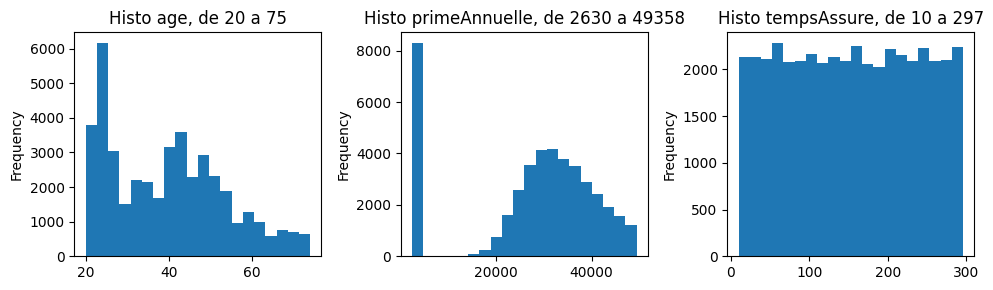

In [ ]:
import matplotlib.pyplot as plt

nrow, ncol = 1, 3
fig, axes = plt.subplots(nrow, ncol, figsize=(10, 3))

# plot counter
count=0
for c in range(ncol):
    q95=df_train[list_quanti[count]].quantile(0.95)
    df_train.loc[df_train[list_quanti[count]]<q95, list_quanti[count]].plot.hist(ax=axes[c],bins=20,
                                                                                    title=f"Histo {list_quanti[count]}, de {df_train[list_quanti[count]].min()} a {int(round(q95,0))}")
    count=count+1

fig.tight_layout()

En augmentant le nombre de bins et en supprimant (juste pour la visualisation) les lignes > quantile 95%, on obtient des graphiques plus interprétables.
*   Les âges et la primeAnnuelle suivent une distribution à deux bosses
    *   On se pose quelques questions sur les primeAnnuelle, car il y a un grand volume et primes à 2630. Nous devrons visualiser ça de plus près.
    *   De plus, notre assureur est à priori une IARD individuelle, vu qu'ils essayent de faire du cross-sell en auto. Il faudra donc étudier les primesAnnuelles les plus importantes, essaye de comprendre pourquoi les chiffres sont aussi élevés, et faire un arbitrage. Une prime annuelle de 5M d'euros sur une IARD indiduelle nous semble très suspect
*   La variable tempAssure est uniforme jusqu'à 95%, ce qui a l'air relativement cohérent.

In [ ]:
df_train["primeAnnuelle"].value_counts()[0:10]

,count
primeAnnuelle,
2630,8299
263000,390
36086,10
31036,9
28430,9
28900,9
32089,8
42009,8
37261,8


Voir les modalités de primeAnnuelle montre que 2630 a l'air d'être une sorte de valeur plancher, ou une valeur placée de façon automatisée. Par contre, le top 10 des fréquences montre 263000, qui a l'air d'être une valeur erronée: Un 2630 mal écrit. Ca laisse se poser des questions sur toutes les valeurs supérieures à 50000 avec deux zéros derrière pour voir ce qu'il en est

<Axes: title={'center': 'primeAnnuelle, deux zéros à droite, >50k, de 263000 à 4991600'}, ylabel='Frequency'>

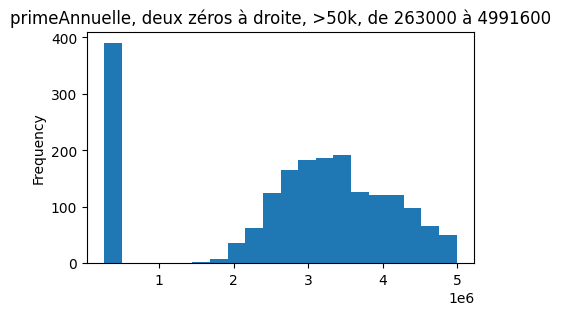

In [ ]:
two_trailing_zeroes=(df_train["primeAnnuelle"].astype(str).str[-2:]=="00")
big_premium=(df_train["primeAnnuelle"]>50000)
min_prime=df_train.loc[big_premium & two_trailing_zeroes,"primeAnnuelle"].min()
max_prime=df_train.loc[big_premium & two_trailing_zeroes,"primeAnnuelle"].max()
df_train.loc[big_premium & two_trailing_zeroes,"primeAnnuelle"].plot.hist(bins=20,
                                                title=f"primeAnnuelle, deux zéros à droite, >50k, de {min_prime} à {max_prime}", figsize=(5, 3))

Voir la distribution des primes supérieures à 100000 nous indique clairement que ça doit être des erreurs de saisie, car c'est la même distribution que les sinistres < quantile 95%. Nous allons donc simplement diviser par 100 pour soustraire les deux 0 et regarder la distribution résultante.

<Axes: title={'center': 'primeAnnuelle apres correction'}, ylabel='Frequency'>

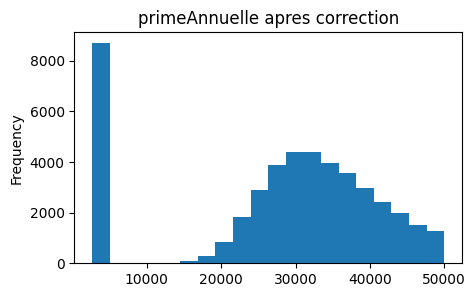

In [ ]:
df_train["feat_prime"]=df_train["primeAnnuelle"]
df_train.loc[big_premium & two_trailing_zeroes,"feat_prime"]=df_train.loc[big_premium & two_trailing_zeroes,"primeAnnuelle"]/100
df_train["feat_prime"].plot.hist(bins=20, title=f"primeAnnuelle apres correction", figsize=(5, 3))

Ceci résoud donc notre problème pour la prime annuelle. Nous allons garder cette étape en tête pour le preprocessing

Pour les âges et le tempsAssure, nous n'avons pas de moyen aussi clair de corriger les valeurs. Nous allons faire deux choses dans le preprocessing:
*   Tronquer les âges et tempsAssure>q95
*   Créer une variable qualitative binaire chaque pour garder l'information de savoir si l'âge/tempsAssure est > q95


In [ ]:
def truncate_quantile(series, quantile=0.95):
    q95=int(series.quantile(quantile))
    series_output=series.copy()
    series_output[series_output>q95]=q95+1
    return series_output

df_train["feat_age"]=truncate_quantile(df_train["age"])
df_train["feat_temps_assure"]=truncate_quantile(df_train["tempsAssure"])

## Variables quantitatives corrigées vs variable cible

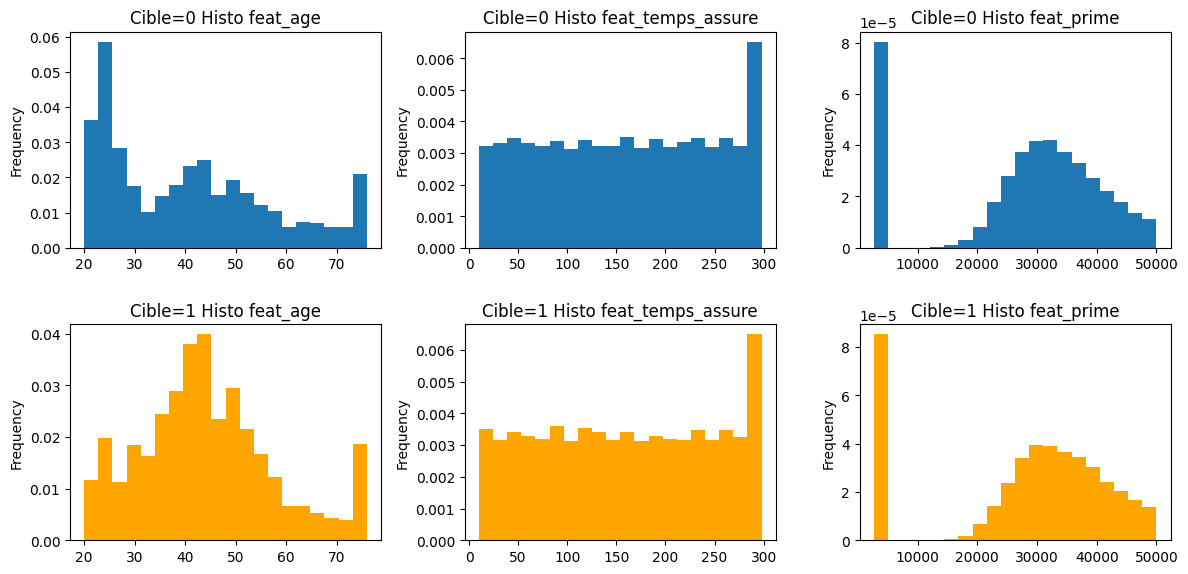

In [ ]:
import matplotlib.pyplot as plt

nrow, ncol = 2, 3
fig, axes = plt.subplots(nrow, ncol, figsize=(12, 6))
list_quanti_feat=["feat_age", "feat_temps_assure", "feat_prime"]
# plot counter
count=0
for c in range(ncol):
    df_train.loc[df_train[target]==0, list_quanti_feat[count]].plot.hist(ax=axes[0,c],bins=20,density = True,
                                title=f"Cible=0 Histo {list_quanti_feat[count]}")
    df_train.loc[df_train[target]==1, list_quanti_feat[count]].plot.hist(ax=axes[1,c],bins=20,density = True,color = "orange",
                                title=f"Cible=1 Histo {list_quanti_feat[count]}")
    count=count+1

fig.tight_layout()

On remarque que la variable âge a le potentiel d'être très influente, puisque la distribution change complètement entre interesse=0 et interesse=1.
Nous ne pensons pas que ce sera la même chose pour le temps assuré ou la prime annuelle, puisque les distributions sont sensiblement les mêmes.

## Pipeline preprocessing quanti

*   Nous allons effectuer les correctifs identifiés pour la variable prime annuelle :
    *   Pour les primes > 50000 et qui se terminent par deux 0 à droite, nous allons diviser par 100
*   Nous allons tronquer les âges et les temps assurés à quantile 95%, et créer des variables qualitatives pour contenir si la valeur dans la colonne correspondante (âge ou temps assuré) était supérieure au quantile 95% pour ne pas perdre l'information
*   Puisque les échelles sont différentes, nous allons opter pour une normalisation min-max pour garantir des variables entre 0 et 1. C'est dû au fait que nous avons des variables binaires (0 ou 1) et ça aidera certains modèles de ne pas avoir des différences d'échelles (notamment knn ou la régression logistique)
    *   Pour éviter le data leakage, nous allons bien sûr nous assurer de calculer les min/max sur le jeu de train et les appliquer sur le jeu d'eval/test

In [ ]:
def preprocess_quanti(df, norm_dict={}):
    feats_quanti=[]
    # on corrige d'abord la prime annuelle
    two_trailing_zeroes=(df["primeAnnuelle"].astype(str).str[-2:]=="00")
    big_premium=(df["primeAnnuelle"]>50000)
    df["feat_prime"]=df["primeAnnuelle"]
    df.loc[big_premium & two_trailing_zeroes,"feat_prime"]=df.loc[big_premium & two_trailing_zeroes,"primeAnnuelle"]/100
    feats_quanti.append("feat_prime")
    # on corrige ensuite les âges
    df["feat_age"]=truncate_quantile(df["age"])
    df["feat_age_q95"]=(df["feat_age"]==df["feat_age"].max()).astype(int)
    feats_quanti.append("feat_age")
    # on corrige enfin le temps assuré
    df["feat_temps_assure"]=truncate_quantile(df["tempsAssure"])
    df["feat_temps_assure_q95"]=(df["feat_temps_assure"]==df["feat_temps_assure"].max()).astype(int)
    feats_quanti.append("feat_temps_assure")
    # on normalise: si on n'a pas de dictionnaire pour normaliser, on en crée un et on l'utilise
    if not norm_dict:
        for col in feats_quanti:
            norm_dict[col]={"min":df[col].min(), "max":df[col].max()}
    for col in feats_quanti:
        df[col]=(df[col]-norm_dict[col]["min"])/(norm_dict[col]["max"]-norm_dict[col]["min"])
        # pour garder la valeur dans le périmètre dans le cas du jeu de test et d'eval
        df.loc[df[col]>1,col]=1
        df.loc[df[col]<0,col]=0
    feats_quanti.extend(["feat_age_q95", "feat_temps_assure_q95"])
    return df, norm_dict, feats_quanti

In [ ]:
df_train, norm_dict, feats_quanti=preprocess_quanti(df_train)
df_eval, _, _=preprocess_quanti(df_eval, norm_dict)
df_test, _, _=preprocess_quanti(df_test, norm_dict)
list_feat.extend(feats_quanti)

## Variables qualitatives avec beaucoup de catégories

Il convient de traiter ces variables à part car d'un côté leur pouvoir prédictif est probablement plus faible (car l'information est éparpillée sur plein de modalités) et de l'autre, les modèles (en particulier ceux basés sur les arbres) auront tendance à surévaluer leur pouvoir prédictif et les utiliser plus souvent.

On va d'abord étudier leurs fréquences (pour savoir si on peut juste se restreindre aux modalités les plus communes). Si les modalités sont éclatées, on peut essayer de les regrouper selon leur pouvoir prédictif.

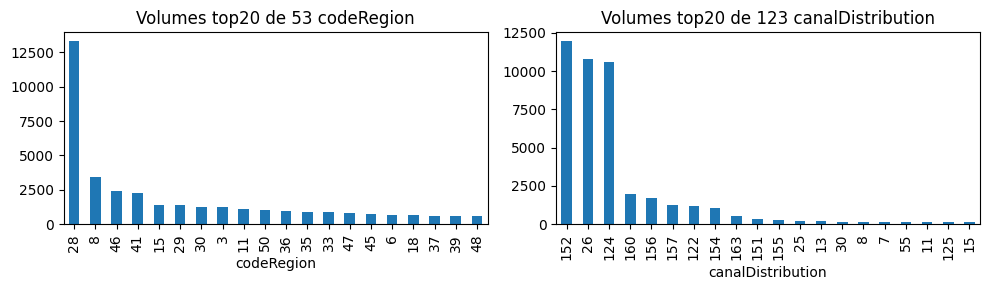

In [ ]:
import matplotlib.pyplot as plt
# make a list of all dataframes
nrow, ncol = 1, 2
fig, axes = plt.subplots(nrow, ncol, figsize=(10, 3))

# plot counter
count=0
for c in range(ncol):
    df_train[list_other[count]].value_counts()[0:20].plot.bar(ax=axes[c], title=f"Volumes top20 de {df_train[list_other[count]].nunique()} {list_other[count]}")
    count=count+1

fig.tight_layout()

Ce premier graphe nous donne deux informations importantes:

*   Il y a un codes région avec une majorité relative, et plein de petits codes région minoritaires
*   Il y a 3 canaux de distribution avec une majorité relative, et plein de codes distributions minoritaires.

Pour faire des décisions informées concernant leur regroupement, il convient de regarder l'effet des modalités sur la variable cible.

## Variables qualitatives avec beaucoup de catégories vs variable cible

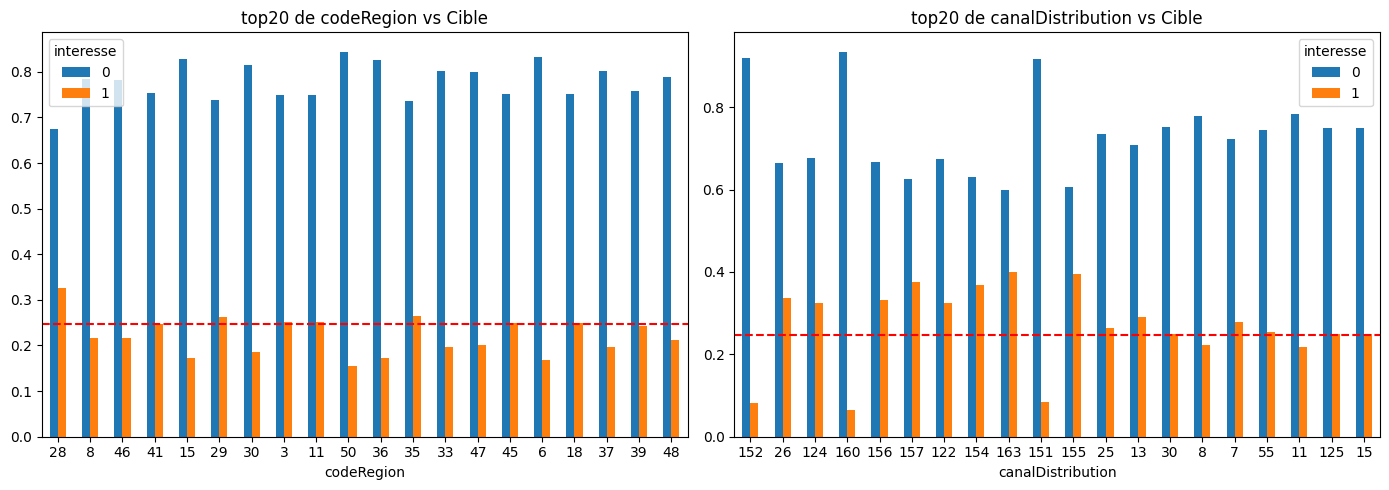

In [ ]:
import matplotlib.pyplot as plt

nrow, ncol = 1, 2
fig, axes = plt.subplots(nrow, ncol, figsize=(14, 5))

# plot counter
count=0
for c in range(ncol):
    top20_index=df_train[list_other[count]].value_counts()[0:20].index
    df_top20=df_train[df_train[list_other[count]].isin(top20_index)]
    pd.crosstab(df_top20[target], df_top20[list_other[count]], normalize="columns")[top20_index].transpose().plot.bar(ax=axes[c],
                                                                                                title=f"top20 de {list_other[count]} vs Cible",rot=0)
    axes[c].axhline(y = target_prop, color = 'r', linestyle = 'dashed')
    count=count+1

fig.tight_layout()

Ce graphe nous indique l'impact de chaque code région ou distribution sur la variable cible. On peut déjà voir que certains codes ont un impact plutôt supérieur à la moyenne (région 28 et 29 par exemple, et canaux 26 et 124), et d'autres avec un impact plutôt inférieur à la moyenne (codes régions 8 et 46, par exemple, et canaux 152 et 161).

Avec ces deux graphes, nous allons opérer la transformation suivante :
*   Les codes dits "majoritaires" (identifiés grâce au "coude" avec le prochain canal le plus fréquent) seront encodés séparément et recevrons leur propre colonne.
*   Les codes dits "minoritaires" (tous les autres codes du train set) seront encodés selon leur effect supérieur à la moyenne ou inférieur à la moyenne sur la variable cible
*   Les codes "inconnus" (codes absents du train set) ne seront pas encodés, mais le code de preprocessing devra les intégrer pour ne pas générer d'erreur lors du preprocessing des jeux de test et d'évaluation.

Enfin, il va sans dire que, pour éviter le data leakage, nous allons identifier ces classes dites "majoritaires" et "minoritaires" sur le train, mais les appliquer sur le test

In [ ]:
import numpy as np

def process_other(df, dict_cat={}):
    no_dict_cat=False
    feats_other=[]
    target_prop=0
    if not dict_cat:
        no_dict_cat=True
        target_prop=df[target].mean()
    list_other=['codeRegion', 'canalDistribution']
    for col in list_other:
        if no_dict_cat:
            dict_cat[col]={}
            # identification des classes majoritaires
            df_proportions=pd.DataFrame(df[col].value_counts(normalize=True)).reset_index(drop=False)
            # on identifie le "coude" comme étant l'instant du plus grand écart absolu d'une catégorie à la suivante
            df_proportions["diff"]=df_proportions.proportion.diff().shift(-1).abs()
            max_prop=df_proportions.loc[df_proportions["diff"]==df_proportions["diff"].max(),"proportion"].iloc[0]
            # les classes majoritaires sont celles à gauche du coude
            dict_cat[col]["list_maj"]=df_proportions.loc[df_proportions.proportion>=max_prop, col].tolist()
            # identification des classes minoritaires positives
            df_other=df[~df[col].isin(dict_cat[col]["list_maj"])]
            df_crosstab=pd.crosstab(df_other[target], df_other[col], normalize="columns").transpose().reset_index()
            # une classe est minoritaire positive si sa proportion de valeurs positives > proportion moyenne du dataset
            dict_cat[col]["list_min_pos"]=df_crosstab.loc[df_crosstab[1]>=target_prop, col].tolist()
            dict_cat[col]["list_min_neg"]=df_crosstab.loc[df_crosstab[1]<target_prop, col].tolist() # respectivement, minoritaire négative
        #application : on initialise la colonne à l'identique pour maintenir les classes majoritaires
        df["feat_"+col]=df[col].astype(str)
        # si une classe appartient aux classes minoritaires (positives ou négatives), elle reçoit le label correspondant
        df.loc[df[col].isin(dict_cat[col]["list_min_pos"]), "feat_"+col]=f"pos"
        df.loc[df[col].isin(dict_cat[col]["list_min_neg"]), "feat_"+col]=f"neg"
        # si une classe n'est dans aucune catégorie, elle reçoit le label "autre"
        df.loc[~df[col].isin(dict_cat[col]["list_maj"]+dict_cat[col]["list_min_pos"]+dict_cat[col]["list_min_neg"]), "feat_"+col]=f"other"
        # on applique un one hot encoding personnalisé pour tenir compte du fait qu'on ne veut pas de "other"
        # on drop également les colonnes minoritaires négatives + other pour éviter les multicolinéarités
        for i in [i for i in df[f"feat_{col}"].unique() if i not in [f"other_{col}", f"neg_{col}"]]:
            df[f"feat_{col}_{i}"]=(df[f"feat_{col}"]==i).astype(int)
            feats_other.append(f"feat_{col}_{i}")

    return df, dict_cat, feats_other

In [ ]:
df_train, dict_cat, feats_other = process_other(df_train)
df_eval, _, _ = process_other(df_eval, dict_cat)
df_test, _, _ = process_other(df_test, dict_cat)
list_feat.extend(feats_other)

### Evaluation de notre preprocessing

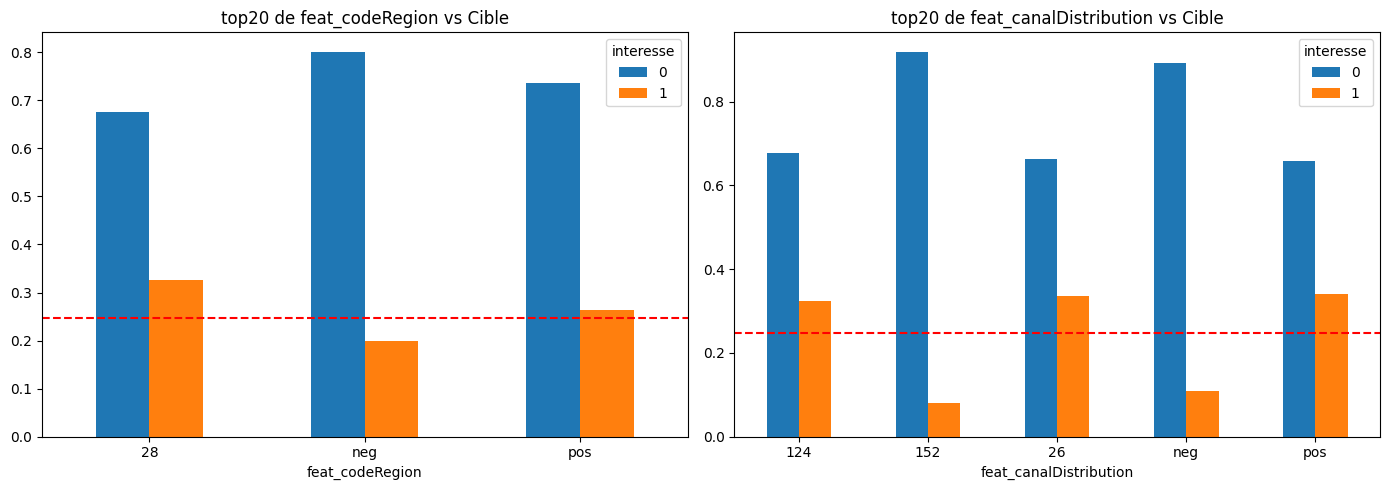

In [ ]:
import matplotlib.pyplot as plt

nrow, ncol = 1, 2
fig, axes = plt.subplots(nrow, ncol, figsize=(14, 5))
feats_other_vis=["feat_codeRegion","feat_canalDistribution"]
# plot counter
count=0
for c in range(ncol):
    pd.crosstab(df_train[target], df_train[feats_other_vis[count]], normalize="columns").transpose().plot.bar(ax=axes[c],
                                                                                                title=f"top20 de {feats_other_vis[count]} vs Cible",rot=0)
    axes[c].axhline(y = target_prop, color = 'r', linestyle = 'dashed')
    count=count+1

fig.tight_layout()

Après regroupement des valeurs selon leur impact potentiel sur la variable cible, on peut arriver à ce graphique qui démontre bien la valeur de nos regroupement, qui sont bien homogènes par rapport à leur impact sur la cible.

# Modélisation - baseline

## Modèle baseline

On doit d'abord construire un modèle dit "baseline", c'est à dire un modèle avec les paramètres par défaut. Nous utilisons ce modèle pour avoir une performance "plancher" pour notre modèle, à laquelle les techniques suivantes vont se mesurer.

Pour cela, il faut d'abord mettre en place une stratégie de validation croisée stratifiée. C'est important dans la mesure où notre y est déséquilibré. Pour pouvoir utiliser les fonctions pré-existantes de sklearn, il faut prendre en compte que notre preprocessing (surtout la partie normalisation) utilise des données sur tout le dataset. Pour éviter le data leakage, nous devons construire une pipeline de preprocessing personnalisé puis entraîner un modèle dessus.

## Pipeline de preprocessing complète

Nous allons donc combiner nos différentes méthodes de preprocessing en une seule pipeline, compatible avec le reste de l'écosystème scikit-learn. Ceci nous permettra d'utiliser des fonctions optimisées pour la validation croisée, le gridsearch et l'évaluation.

In [ ]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

class Preprocessor(BaseEstimator, TransformerMixin):
# la classe doit avoir des fonctions que sklearn connaît
# telles que fit, transform et fit_transform
# sklearn la traitera donc comme un modèle comme les autres
  def __init__(self, list_feat):
    self.norm_dict = None
    self.dict_cat = None
    self.list_feat = list_feat
    return None

  def fit(self, X, y=None):
    self.fit_transform(X)
    return self

  def fit_transform(self, X, y=0):
    # fit_transform gère le jeu de train et initialise les valeurs
    X, _=preprocess_quali(X.copy())
    X, self.norm_dict, _=preprocess_quanti(X)
    X, self.dict_cat, _=process_other(X)
    return X[self.list_feat]

  def transform(self, X):
    # transform sert à traiter le jeu de test avec les valeurs déjà initialisées
    # grâce au jeu de train
    X, _=preprocess_quali(X.copy())
    if self.norm_dict:
        X, _, _=preprocess_quanti(X, self.norm_dict)
    else:
        print("no norm_dict initialized")
        raise ValueError
    if self.dict_cat:
        X, _, _=process_other(X, self.dict_cat)
    else:
        print("no dict_cat initialized")
        raise ValueError
    return X[self.list_feat]

Avec cette classe de preprocessing, on peut initialiser une pipeline "baseline", qui reçoit les données, les prépare et fait la prédiction.

In [ ]:
from sklearn.linear_model import LogisticRegression

training_pipeline_baseline = Pipeline(steps=[
        ('preprocessing', Preprocessor(list_feat=list_feat)),
        ('model', LogisticRegression()),
    ])

## Validation croisée du modèle baseline

Nous allons faire une validation croisée sur 5 découpages aléatoires stratifiés. Ils sont stratifiés car nos données sont déséquilibrées

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

scoring = {"AUC": "roc_auc", "f1_score": "f1", "precision":"precision", "recall_score":"recall" }

results=pd.DataFrame(cross_validate(training_pipeline_baseline, df_train, df_train[target],
                                    cv=StratifiedKFold(5), scoring=list(scoring.values()))).mean().transpose()
results

,0
fit_time,2.168031
score_time,0.746021
test_roc_auc,0.881431
test_f1,0.651435
test_precision,0.588737
test_recall,0.729180


## Courbe ROC et matrice de confusion

Nous allons définir notre propre fonction d'évaluation, qui permettra de visualiser la matrice de confusion et la courbe roc, ainsi que de générer des métriques pour un modèle donné

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

def evaluate_model(model, df, list_feat, target, label=None, plot=True, print_report=True):
    if not label:
        label=f"baseline_{model.__class__.__name__}"
    # Predictions
    y_pred = model.predict(df)
    try: # certains modèles (comme SVM) ne peuvent pas fournir de probas
        y_proba = model.predict_proba(df)[:, 1]
    except:
        y_proba = y_pred
    y_true = df[target]
    # Classification Report
    if print_report:
        print(classification_report(y_true, y_pred))

    if plot:
        # Confusion Matrix
        fig, axes = plt.subplots(figsize = (8,3), ncols = 2)
        cm = confusion_matrix(y_true, y_pred, labels=model.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=model.classes_)
        disp.plot(ax=axes[0])

        # Confusion Matrix
        axes[0].set_title(f"Confusion Matrix {label}", fontsize=10)

        # ROC-AUC Curve
        fpr, tpr, thresholds = roc_curve(y_true, y_proba)
        roc_auc = auc(fpr, tpr)
        display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                        estimator_name=label)
        display.plot(ax=axes[1])

        axes[1].legend()
        axes[1].plot([0,1], [0,1], ls = ':')
        axes[1].grid()
        axes[1].set_title(f"ROC-AUC Plot {label}", fontsize=10)
        fig.tight_layout()
        plt.show()
    return {
        "label":label,
        "f1_score":f1_score(y_true, y_pred),
        "auc":roc_auc_score(y_true, y_proba),
        "precision":precision_score(y_true, y_pred),
        "recall":recall_score(y_true, y_pred),
    }

              precision    recall  f1-score   support

           0       0.90      0.83      0.87      3761
           1       0.59      0.74      0.65      1239

    accuracy                           0.81      5000
   macro avg       0.75      0.78      0.76      5000
weighted avg       0.83      0.81      0.81      5000



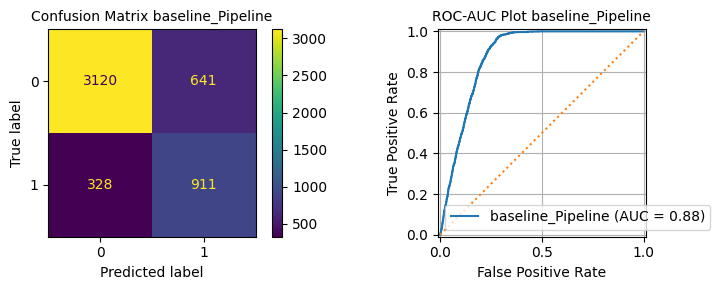

In [ ]:
from time import time

results_list=[]
# évaluation du modèle baseline sur le jeu d'évaluation
default_params={"C":1, "class_weight":None, "solver":"lbfgs"}
a=time()
model = training_pipeline_baseline.fit(df_train, df_train[target])

results_list.append( dict(evaluate_model(model, df_eval, list_feat, target), **{"model":model,'time':time()-a,'params':default_params})  )

# Optimisation automatique d'hyperparamètres

Nous avons prévu une liste d'hyperparamètres à couvrir pour chacun des modèles qui nous intéressent. Nous allons tester la régression logistique, SVM, KNN, le random forest et le gradient boosting à base d'histogrammes - ce dernier car plus rapide que l'implémentation classique.


In [ ]:
from sklearn.ensemble import RandomForestClassifier,HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

parameters_list =[
        {
            "label":"random_forest",
            "class":RandomForestClassifier(),
            "grid":
             {
                'model__n_estimators' : [ 100, 200, 400],
                'model__max_depth' : [5, 10],
                "model__class_weight":["balanced", None],
                'model__min_samples_leaf' : [0.001, 0.005, 0.01],
                "model__n_jobs":[-1]
            }
        },
        {
            "label":"logistic_regression",
            "class":LogisticRegression(),
            "grid":
             {
                'model__solver' : ["saga", "lbfgs"],
                'model__C' : [1, 10, 100],
                "model__class_weight":["balanced", None],
                "model__n_jobs":[-1]
            }
        },
        {
            "label":"decision_tree",
            "class":DecisionTreeClassifier(),
            "grid":
             {
                'model__min_samples_leaf' : [1, 0.001, 0.005, 0.01],
                "model__class_weight":["balanced", None],
                'model__max_depth' : [10, 15, 25],
                "model__max_features":["sqrt", "log2", None],
                "model__criterion":["gini", "entropy"]
            }
        },
        {
            "label":"knn",
            "class":KNeighborsClassifier(),
            "grid":
            {
                'model__n_neighbors' : [3, 5],
                'model__weights' : ['uniform', 'distance'],
                'model__algorithm' : ['ball_tree']
            }

        },
        {
            "label":"svm",
            "class":SVC(),
            "grid":
            {
                'model__C' : [1, 10],
                'model__kernel' : ['rbf'],
                'model__class_weight' : ['balanced', None]
            }
        },
        {
            "label":"gradient_boosting",
            "class":HistGradientBoostingClassifier(),
            "grid":
            {
                'model__max_iter' : [100, 200, 400],
                'model__max_depth' : [5, 10, 15],
                "model__class_weight":["balanced", None],
                'model__min_samples_leaf' : [20, 40, 100],
                "model__n_iter_no_change":[5]
            }
        }
]

Nous allons utiliser le RandomSearch à la place du GridSearch. Celui-ci teste un sous-ensemble de toutes les combinaisons des paramètres que nous lui proposons. Nous faisons ce choix par besoin de vitesse, car pour chaque combinaison (et il peut y en avoir des centaines), nous allons entraîner autant de modèles que de sous-ensemble de validation croisée.

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

def get_best_model(df_train, model_card, scoring):
    # model_card=[parameters for parameters in parameters_list if parameters["label"]==model_label][0]

    training_pipeline = Pipeline(steps=[
            ('preprocessing', Preprocessor(list_feat=list_feat)),
            ('model', model_card["class"]),
        ])
    grid_search=RandomizedSearchCV(training_pipeline, model_card["grid"],refit=False,
                            scoring=scoring, return_train_score=True,n_jobs=-1,n_iter=30,
                            cv=StratifiedKFold(3))
    best_model=grid_search.fit(df_train, df_train[target])
    cols_eval=["params","mean_fit_time", "mean_test_f1_score",
               "mean_test_AUC", "mean_test_recall_score","mean_test_precision"]
    df_results=(pd.DataFrame({k:v for k,v in best_model.cv_results_.items() if k in cols_eval}).
                        sort_values("mean_test_f1_score", ascending=False))
    return df_results[cols_eval].iloc[0]

La boucle suivante va d'abord, pour un modèle donnée, faire un RandomSearch, testant un sous-ensemble des combinaisons possibles d'hyperparamètres. Elle va ensuite récupérer le meilleur jeu de paramètres (basé sur le f1-score) puis entraîner un modèle avec ce jeu de paramètres et l'évaluer sur le jeu d'évaluation. Enfin, elle rajoutera le modèle, ses paramètres et ses résultats dans le tableau de résultat que nous utiliserons pour faire un benchmark de nos différentes approches.

In [ ]:
from time import time

for model_card in parameters_list:
    print(model_card["label"])
    a=time()
    best_model=get_best_model(df_train, model_card, scoring)
    params = {key.replace("model__",""):value for key,value in best_model["params"].items()}
    training_pipeline = Pipeline(steps=[
            ('preprocessing', Preprocessor(list_feat=list_feat)),
            ('model', model_card["class"].__class__(**params)),
        ])
    model = (training_pipeline.fit(df_train, df_train[target]))
    results = evaluate_model(model, df_eval, list_feat, target,label=model_card["label"], plot=False, print_report=False)
    results = dict(results, **{"model":model,'time':time()-a,'params':params})
    results_list.append(results)
    print(f"total training time {results['time']} best f1 score {results['f1_score']}")



random_forest
total training time 416.16597390174866 best f1 score 0.6901241868716735
logistic_regression
total training time 48.79865527153015 best f1 score 0.68270591565242
decision_tree
total training time 58.3022301197052 best f1 score 0.689090377303305
knn
total training time 649.8630564212799 best f1 score 0.5773524720893142
svm
total training time 1398.4360342025757 best f1 score 0.6911548633558625
gradient_boosting
total training time 131.15081310272217 best f1 score 0.6903169526025007


In [ ]:
pd.DataFrame(results_list)

,label,f1_score,auc,precision,recall,model,time,params
0,baseline_Pipeline,0.652813,0.882690,0.586985,0.735270,"(Preprocessor(list_feat=['feat_permis', 'feat_...",2.618617,"{'C': 1, 'class_weight': None, 'solver': 'lbfgs'}"
1,random_forest,0.690124,0.881747,0.544564,0.941889,"(Preprocessor(list_feat=['feat_permis', 'feat_...",416.165974,"{'n_jobs': -1, 'n_estimators': 200, 'min_sampl..."
2,logistic_regression,0.682706,0.882245,0.525719,0.973366,"(Preprocessor(list_feat=['feat_permis', 'feat_...",48.798655,"{'solver': 'lbfgs', 'n_jobs': -1, 'class_weigh..."
3,decision_tree,0.689090,0.886300,0.540367,0.950767,"(Preprocessor(list_feat=['feat_permis', 'feat_...",58.302230,"{'min_samples_leaf': 0.01, 'max_features': Non..."
4,knn,0.577352,0.852486,0.570528,0.584342,"(Preprocessor(list_feat=['feat_permis', 'feat_...",649.863056,"{'weights': 'uniform', 'n_neighbors': 5, 'algo..."
5,svm,0.691155,0.843228,0.543438,0.949153,"(Preprocessor(list_feat=['feat_permis', 'feat_...",1398.436034,"{'kernel': 'rbf', 'class_weight': 'balanced', ..."
6,gradient_boosting,0.690317,0.889831,0.539545,0.958031,"(Preprocessor(list_feat=['feat_permis', 'feat_...",131.150813,"{'n_iter_no_change': 5, 'min_samples_leaf': 10..."


Nous allons enregistrer ce premier jeu de résulats pour ne pas avoir à réexécuter le bloc de code - très - chronophage de RandomSearch. La suite se fera en partant sur les meilleurs paramètres choisis dans la première étape.

In [ ]:
pd.DataFrame(results_list).to_pickle("/content/drive/My Drive/Projet CNAM/df_results.pkl")

# Sélection automatique du meilleur seuil

Puisque nous sommes dans une situation de modélisation déséquilibrée, le seuil par défaut de scikit-learn en classification de 0.5 nous paraît inapproprié. Pour cela, nous allons optimiser automatiquement le seuil par validation croisée et en utilisant le f1-score comme métrique.

In [ ]:
df_results=pd.read_pickle("/content/drive/My Drive/Projet CNAM/df_results.pkl")

In [ ]:
from sklearn.model_selection import TunedThresholdClassifierCV
from sklearn.metrics import make_scorer, f1_score

def tune_thresh_classifier(model_init, df, target):
    model = TunedThresholdClassifierCV(model_init, scoring=make_scorer(f1_score, pos_label=1),
                                    cv=StratifiedKFold(2))
    model.fit(df, df[target])
    return model

def tune_thresh_models(df_results, df_train, target, df_eval, list_feat):
    df_results_thresh=df_results.copy()
    df_results_thresh["model"]=df_results_thresh.model.apply(lambda x: tune_thresh_classifier(x, df_train, target))
    df_results_thresh["thresh"]=df_results_thresh.model.apply(lambda model:model.best_threshold_)
    scores_series=df_results_thresh.apply(lambda row: evaluate_model(row["model"], df_eval, list_feat, target,
                                                label=row["label"], plot=False, print_report=False), axis=1)

    df_results_thresh=df_results_thresh.drop(columns=["f1_score","auc","precision","recall  "]).merge(pd.DataFrame(list(scores_series)))
    df_results_thresh["label"]=df_results_thresh["label"]+"_thresh"
    return df_results_thresh

In [ ]:
df_results_thresh=tune_thresh_models(df_results, df_train, target, df_eval, list_feat)
df_results["thresh"]=0.5
df_results=pd.concat([df_results, df_results_thresh]).reset_index(drop=True)
df_results.to_pickle("/content/drive/My Drive/Projet CNAM/df_results_2.pkl")

Pareillement, nous enregistrons les résultats quelque part pour ne pas avoir à relancer cette partie du code.

In [ ]:
df_results = pd.read_pickle("/content/drive/My Drive/Projet CNAM/df_results_2.pkl")

In [ ]:
df_results.sort_values(by=["f1_score"], ascending=False)

,label,f1_score,auc,precision,recall,model,time,params,thresh
13,gradient_boosting_thresh,0.698685,0.889794,0.562562,0.921711,TunedThresholdClassifierCV(cv=StratifiedKFold(...,131.150813,"{'n_iter_no_change': 5, 'min_samples_leaf': 10...",0.591778
12,svm_thresh,0.697187,0.845436,0.553971,0.940274,TunedThresholdClassifierCV(cv=StratifiedKFold(...,1398.436034,"{'kernel': 'rbf', 'class_weight': 'balanced', ...",0.904403
5,svm,0.691155,0.843228,0.543438,0.949153,"(Preprocessor(list_feat=['feat_permis', 'feat_...",1398.436034,"{'kernel': 'rbf', 'class_weight': 'balanced', ...",0.500000
7,baseline_Pipeline_thresh,0.690476,0.882690,0.564260,0.889427,TunedThresholdClassifierCV(cv=StratifiedKFold(...,2.618617,"{'C': 1, 'class_weight': None, 'solver': 'lbfgs'}",0.337685
6,gradient_boosting,0.690317,0.889831,0.539545,0.958031,"(Preprocessor(list_feat=['feat_permis', 'feat_...",131.150813,"{'n_iter_no_change': 5, 'min_samples_leaf': 10...",0.500000
8,random_forest_thresh,0.690255,0.881324,0.549141,0.928975,TunedThresholdClassifierCV(cv=StratifiedKFold(...,416.165974,"{'n_jobs': -1, 'n_estimators': 200, 'min_sampl...",0.526051
1,random_forest,0.690124,0.881747,0.544564,0.941889,"(Preprocessor(list_feat=['feat_permis', 'feat_...",416.165974,"{'n_jobs': -1, 'n_estimators': 200, 'min_sampl...",0.500000
9,logistic_regression_thresh,0.689741,0.882245,0.561992,0.892655,TunedThresholdClassifierCV(cv=StratifiedKFold(...,48.798655,"{'solver': 'lbfgs', 'n_jobs': -1, 'class_weigh...",0.600905
3,decision_tree,0.689090,0.886300,0.540367,0.950767,"(Preprocessor(list_feat=['feat_permis', 'feat_...",58.302230,"{'min_samples_leaf': 0.01, 'max_features': Non...",0.500000
10,decision_tree_thresh,0.688244,0.886300,0.553536,0.909605,TunedThresholdClassifierCV(cv=StratifiedKFold(...,58.302230,"{'min_samples_leaf': 0.01, 'max_features': Non...",0.619998


# Imbalanced learning : SMOTE

Puisque le dataset est déséquilibré, on est attirés par l'idée d'utiliser SMOTE, une technique de suréchantillonage synthétique. C'est à dire, que la technique essaye de générer des exemples de la classe minoritaire de façon synthétique - en modifiant légèrement de façon aléatoire les différentes valeurs des colonnes dans l'échantillon de la classe minoritaire.

In [ ]:
list_feats_quali=[i for i in list_feat if i not in ['feat_prime','feat_age', 'feat_temps_assure']]

In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTENC

from time import time
import warnings
warnings.filterwarnings('ignore')

best_params=df_results.loc[~df_results["label"].str.contains("thresh|baseline",regex=True), ["label","params"]]
best_params=dict(zip(best_params.label, best_params.params))

results_smote=[]
for model_card in parameters_list:
    print(model_card["label"])
    a=time()
    training_pipeline = Pipeline(steps=[
        ('preprocessing', Preprocessor(list_feat=list_feat)),
        ('sampler', SMOTENC(sampling_strategy="minority", categorical_features=list_feats_quali)),
        ('model', model_card["class"].__class__(**best_params[model_card["label"]])),
    ])
    model = (training_pipeline.fit(df_train, df_train[target]))
    results = evaluate_model(model, df_eval, list_feat, target,label=model_card["label"], plot=False, print_report=False)
    results = dict(results, **{"model":model,'time':time()-a,'params':best_params[model_card["label"]]})
    results_smote.append(results)
    print(f"total training time {results['time']} best f1 score {results['f1_score']}")



random_forest
total training time 31.242206573486328 best f1 score 0.6918759231905466
logistic_regression
total training time 24.04961371421814 best f1 score 0.6841206602162777
decision_tree
total training time 19.971654176712036 best f1 score 0.6847953216374268
knn
total training time 33.56120014190674 best f1 score 0.65234375
svm
total training time 356.2275173664093 best f1 score 0.6928529238038984
gradient_boosting
total training time 21.810917854309082 best f1 score 0.6875379939209726


On enregistre ces résultats car SMOTE est *très* chronophage, avant de faire un tuning des seuils sur la pipeline incluant SMOTE.

In [ ]:
df_results_smote=pd.DataFrame(results_smote)
df_results_smote["label"]=df_results_smote["label"]+"_smote"
df_results_smote.to_pickle("/content/drive/My Drive/Projet CNAM/df_results_smote.pkl")
df_results_smote

,label,f1_score,auc,precision,recall,model,time,params
0,random_forest_smote,0.691876,0.881356,0.545666,0.945117,"(Preprocessor(list_feat=['feat_permis', 'feat_...",31.242207,"{'n_jobs': -1, 'n_estimators': 200, 'min_sampl..."
1,logistic_regression_smote,0.684121,0.881932,0.528352,0.970137,"(Preprocessor(list_feat=['feat_permis', 'feat_...",24.049614,"{'solver': 'lbfgs', 'n_jobs': -1, 'class_weigh..."
2,decision_tree_smote,0.684795,0.874994,0.536910,0.945117,"(Preprocessor(list_feat=['feat_permis', 'feat_...",19.971654,"{'min_samples_leaf': 0.01, 'max_features': Non..."
3,knn_smote,0.652344,0.856622,0.546645,0.808717,"(Preprocessor(list_feat=['feat_permis', 'feat_...",33.561200,"{'weights': 'uniform', 'n_neighbors': 5, 'algo..."
4,svm_smote,0.692853,0.843879,0.546344,0.946731,"(Preprocessor(list_feat=['feat_permis', 'feat_...",356.227517,"{'kernel': 'rbf', 'class_weight': 'balanced', ..."
5,gradient_boosting_smote,0.687538,0.887264,0.551438,0.912833,"(Preprocessor(list_feat=['feat_permis', 'feat_...",21.810918,"{'n_iter_no_change': 5, 'min_samples_leaf': 10..."


In [ ]:
df_results_smote=pd.read_pickle("/content/drive/My Drive/Projet CNAM/df_results_smote.pkl")
df_results_smothresh=tune_thresh_models(df_results_smote, df_train, target, df_eval, list_feat)
df_results_smothresh.to_pickle("/content/drive/My Drive/Projet CNAM/df_results_thresh.pkl")

In [ ]:
df_results_smothresh["label"]=df_results_smothresh["label"]+"_smote"
df_results_smothresh

,label,model,time,params,thresh,f1_score,auc,precision,recall
0,random_forest_thresh_smote,TunedThresholdClassifierCV(cv=StratifiedKFold(...,31.242207,"{'n_jobs': -1, 'n_estimators': 200, 'min_sampl...",0.564483,0.687075,0.882309,0.556892,0.896691
1,logistic_regression_thresh_smote,TunedThresholdClassifierCV(cv=StratifiedKFold(...,24.049614,"{'solver': 'lbfgs', 'n_jobs': -1, 'class_weigh...",0.629077,0.686869,0.882016,0.564023,0.878128
2,decision_tree_thresh_smote,TunedThresholdClassifierCV(cv=StratifiedKFold(...,19.971654,"{'min_samples_leaf': 0.01, 'max_features': Non...",0.565476,0.687593,0.883708,0.546059,0.928168
3,knn_thresh_smote,TunedThresholdClassifierCV(cv=StratifiedKFold(...,33.561200,"{'weights': 'uniform', 'n_neighbors': 5, 'algo...",0.202020,0.667858,0.856697,0.529273,0.904762
4,svm_thresh_smote,TunedThresholdClassifierCV(cv=StratifiedKFold(...,356.227517,"{'kernel': 'rbf', 'class_weight': 'balanced', ...",0.738521,0.696461,0.844354,0.554177,0.937046
5,gradient_boosting_thresh_smote,TunedThresholdClassifierCV(cv=StratifiedKFold(...,21.810918,"{'n_iter_no_change': 5, 'min_samples_leaf': 10...",0.445759,0.688134,0.883098,0.545626,0.931396


In [ ]:
df_results_smothresh=pd.read_pickle("/content/drive/My Drive/Projet CNAM/df_results_thresh.pkl")

# Construction du modèle final

Une fois qu'on a testé toutes ces approches, nous allons combiner tous les tableaux de résultats en un seul pour récupérer la meilleure.

## Entraînement du meilleur modèle

Nous allons donc entraîner un modèle avec cette combinaison approche x paramètres x seuil, appliquer ce modèle sur le jeu de test et tester certaines méthodes d'interprétation et d'étude du biais par rapport à certaines variables que l'on pourrait considérer comme sensibles.

In [ ]:
df_results_final=pd.concat([df_results, df_results_smote, df_results_smothresh]).reset_index(drop=True)

In [ ]:
df_results_final=df_results_final.sort_values(by=["f1_score"], ascending=False)
df_results_final.to_pickle("/content/drive/My Drive/Projet CNAM/df_results_final.pkl")

In [ ]:
df_results_final=pd.read_pickle("/content/drive/My Drive/Projet CNAM/df_results_final.pkl").reset_index(drop=True)

In [ ]:
df_results_final

,label,f1_score,auc,precision,recall,model,time,params,thresh
0,gradient_boosting_thresh,0.698685,0.889794,0.562562,0.921711,TunedThresholdClassifierCV(cv=StratifiedKFold(...,131.150813,"{'n_iter_no_change': 5, 'min_samples_leaf': 10...",0.591778
1,svm_thresh,0.697187,0.845436,0.553971,0.940274,TunedThresholdClassifierCV(cv=StratifiedKFold(...,1398.436034,"{'kernel': 'rbf', 'class_weight': 'balanced', ...",0.904403
2,svm_thresh_smote,0.696461,0.844354,0.554177,0.937046,TunedThresholdClassifierCV(cv=StratifiedKFold(...,356.227517,"{'kernel': 'rbf', 'class_weight': 'balanced', ...",0.738521
3,svm_smote,0.692853,0.843879,0.546344,0.946731,"(Preprocessor(list_feat=['feat_permis', 'feat_...",356.227517,"{'kernel': 'rbf', 'class_weight': 'balanced', ...",NaN
4,random_forest_smote,0.691876,0.881356,0.545666,0.945117,"(Preprocessor(list_feat=['feat_permis', 'feat_...",31.242207,"{'n_jobs': -1, 'n_estimators': 200, 'min_sampl...",NaN
5,svm,0.691155,0.843228,0.543438,0.949153,"(Preprocessor(list_feat=['feat_permis', 'feat_...",1398.436034,"{'kernel': 'rbf', 'class_weight': 'balanced', ...",0.500000
6,baseline_Pipeline_thresh,0.690476,0.882690,0.564260,0.889427,TunedThresholdClassifierCV(cv=StratifiedKFold(...,2.618617,"{'C': 1, 'class_weight': None, 'solver': 'lbfgs'}",0.337685
7,gradient_boosting,0.690317,0.889831,0.539545,0.958031,"(Preprocessor(list_feat=['feat_permis', 'feat_...",131.150813,"{'n_iter_no_change': 5, 'min_samples_leaf': 10...",0.500000
8,random_forest_thresh,0.690255,0.881324,0.549141,0.928975,TunedThresholdClassifierCV(cv=StratifiedKFold(...,416.165974,"{'n_jobs': -1, 'n_estimators': 200, 'min_sampl...",0.526051
9,random_forest,0.690124,0.881747,0.544564,0.941889,"(Preprocessor(list_feat=['feat_permis', 'feat_...",416.165974,"{'n_jobs': -1, 'n_estimators': 200, 'min_sampl...",0.500000


In [ ]:
best_params_gb=df_results_final.params[0]
best_thresh=df_results_final.thresh[0]
label=df_results_final.label[0]

In [ ]:
best_params_gb

{'n_iter_no_change': 5,
 'min_samples_leaf': 100,
 'max_iter': 400,
 'max_depth': 10,
 'class_weight': 'balanced'}

In [ ]:
list_feat=['feat_permis', 'feat_sans_assurance', 'feat_accident', 'feat_homme',
            'feat_age_vehicule>1', 'feat_prime', 'feat_age', 'feat_temps_assure',
            'feat_age_q95', 'feat_temps_assure_q95', 'feat_codeRegion_neg',
            'feat_codeRegion_pos', 'feat_codeRegion_28', 'feat_canalDistribution_26',
            'feat_canalDistribution_pos', 'feat_canalDistribution_neg', 'feat_canalDistribution_152',
            'feat_canalDistribution_124']

              precision    recall  f1-score   support

           0       0.97      0.76      0.85      3761
           1       0.56      0.93      0.70      1239

    accuracy                           0.80      5000
   macro avg       0.76      0.84      0.77      5000
weighted avg       0.87      0.80      0.81      5000



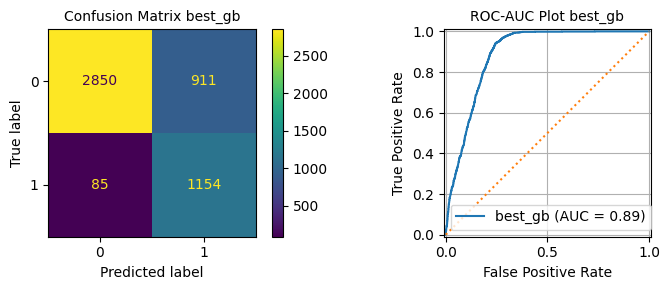

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold

training_pipeline = Pipeline(steps=[
        ('preprocessing', Preprocessor(list_feat=list_feat)),
        ('model', HistGradientBoostingClassifier(**best_params_gb)),
    ])
model = (training_pipeline.fit(df_train, df_train[target]))

model = tune_thresh_classifier(model, df_train, target)

results = evaluate_model(model, df_eval, list_feat, target,label="best_gb", plot=True, print_report=True)

In [ ]:
results

{'label': 'best_gb',
 'f1_score': 0.698547215496368,
 'auc': 0.8890435781701629,
 'precision': 0.5588377723970944,
 'recall': 0.9313962873284907}

On enregistre le modèle final et les informations nécessaires pour l'utiliser

In [ ]:
import pickle

model_card = {
    "label":label,
    "list_feat":list_feat,
    "target":target,
    "model":model
}

filename = f"{root_path}/best_model.pkl"

pickle.dump(model_card, open(filename, 'wb'))

## Interprétation du modèle avec SHAP

SHAP est une méthode qui permet de générer de l'interprétabilité à partir de modèles en boîte noire. La méthode se base sur l'analyse de la variabilité de la prédiction selon la variabilité des variables d'entrée. Elle fait plusieurs milliers d'itérations aléatoires, à chacune, elle prend un individu, et dans cet individu, elle prend une colonne aléatoirement, puis change sa valeur et interprète la variation de la prédiction du modèle. Pour chaque colonne, cette opération faite plusieurs fois donne l'impact de la variation de cette colonne à chaque fois, et si on applique la moyenne, ça donne l'impact moyen de la variation de la colonne dans l'absolu. Ceci donne donc le graphe suivant, avec l'impact positif ou négatif de chaque variable.

In [ ]:
import shap

def build_shap(model, train, features):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(train[features])

    return shap.summary_plot(shap_values, train, sort=False)

In [ ]:
estimator=model.estimator.steps[-1][-1]
preprocessor = Preprocessor(list_feat=list_feat)
df_train_preprocessed = preprocessor.fit_transform(df_train)
df_eval_preprocessed = preprocessor.transform(df_eval)

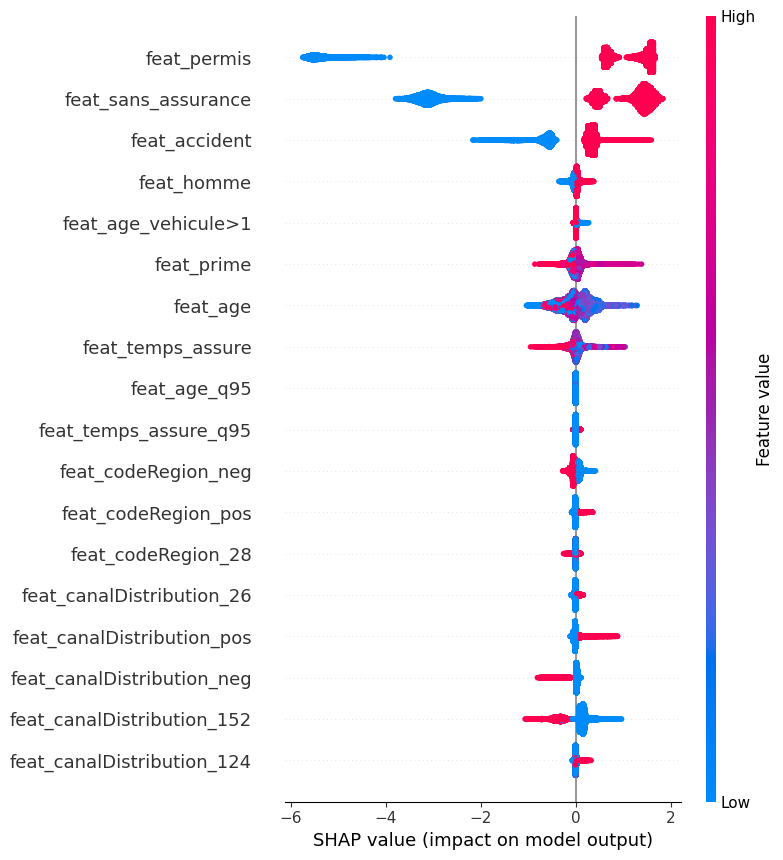

In [ ]:
build_shap(estimator, df_train_preprocessed, list_feat)

Une lecture de ce graphe, notamment la variable feat_permis, donne l'information suivante : Quand la personne a le permis ("rouge"), ça augmente les chances de vouloir acheter l'offre ("à droite de zéro"). Par contre, quand le canal distribution = 152 ("rouge"), ça diminue les chances de vouloir acheter l'offre ("à gauche de zéro"). Cette façon de regarder la couleur (rouge pour valeur positive, bleu pour valeur négative) et la position des points (à droite de zéro pour un impact positif sur la cible, à gauche de zéro pour un impact négatif) permet de faire des interprétations similaires pour le reste des variables.

## Expérimentations sur le biais par rapport à des variables sensibles

A ce stade, nous allons supposer que le sexe (représenté par feat_homme) est une variable sensible, par rapport à laquelle nous voulons débiaiser notre modèle. L'objectif est d'atteindre la "parité démographique", qui est l'état lorsque les scores sont similaires en densité entre les sous-populations.

Il y a plusieurs façons d'aborder le problème: Soit dans le preprocessing et le choix des variables, soit dans le modèle lui-même, soit en postprocessing des valeurs prédites. En postprocessing, ça correspond à l'ajustement des scores prédits pour optimiser une métrique d'équité choisie. Nous retenons la dernière approche - en utilisant la méthode des barycentres de Wasserstein dans notre exemple - car elle permet d'avoir certains avantages:

- Ca permet de visualiser directement l'impact du process de suppression du biais
- La méthode est agnostique du modèle, car elle considère que celui-ci est une boîte noire qui fournit des scores, sans plus
- Elle permet de gérer potentiellement plusieurs attributs sensibles et l'output est directement un score débiaisé

L'idée est d'abord de séparer le dataset en deux, de façon à pouvoir visualiser séparément les densités des prédictions du segment masculin et féminin. Par la suite, le théorème garantit que le modèle le plus équitable d'un point de vue théorique correspond à celui dont la densité est celle du barycentre de Wasserstein - qui est une métrique de distance permettant de mesurer l'inéquité. On transforme dès lors les deux distributions pour qu'elles coïncident avec ce barycentre, permettant d'avoir ainsi un modèle équitable, avec un impact relativement minimal sur la performance du modèle.

En pratique, ça nécessite de passer par les étapes suivantes:

- Nous allons calibrer le "modèle" de Wasserstein avec les scores obtenus sur le jeu de train
- Cette calibration nous permet d'obtenir la densité selon le barycentre de Wasserstein, et de l'appliquer pour ajuster les scores obtenus sur le jeu de test
- Les scores transformés peuvent être transformés en valeur binaire (0 ou 1) avec le seuil calculé précédemment

In [ ]:
from equipy.fairness import FairWasserstein
from equipy.graphs import fair_waterfall_plot

wasserstein = FairWasserstein(sigma=0.001)
y_train_proba=model.predict_proba(df_train)[:, 1]
y_eval_proba=model.predict_proba(df_eval)[:, 1]

wasserstein.fit(y_train_proba, sensitive_feature=df_train[["feat_homme"]])
y_eval_fair=wasserstein.transform(y_eval_proba, sensitive_feature=df_eval[["feat_homme"]], epsilon=0.2)

Le graphique suivant permet de visualiser la densité de la variable score avant et après ajustement, et permet de visualiser qu'on atteint bien la parité démographique, avec les deux densités quasi-superposées.

array([[<Axes: xlabel='Base model predictions', ylabel='Density'>,
        <Axes: xlabel='Fair predictions in feat_homme', ylabel='Density'>],
       [<Axes: xlabel='Base model predictions', ylabel='Density'>,
        <Axes: xlabel='Fair predictions in feat_homme', ylabel='Density'>]],
      dtype=object)

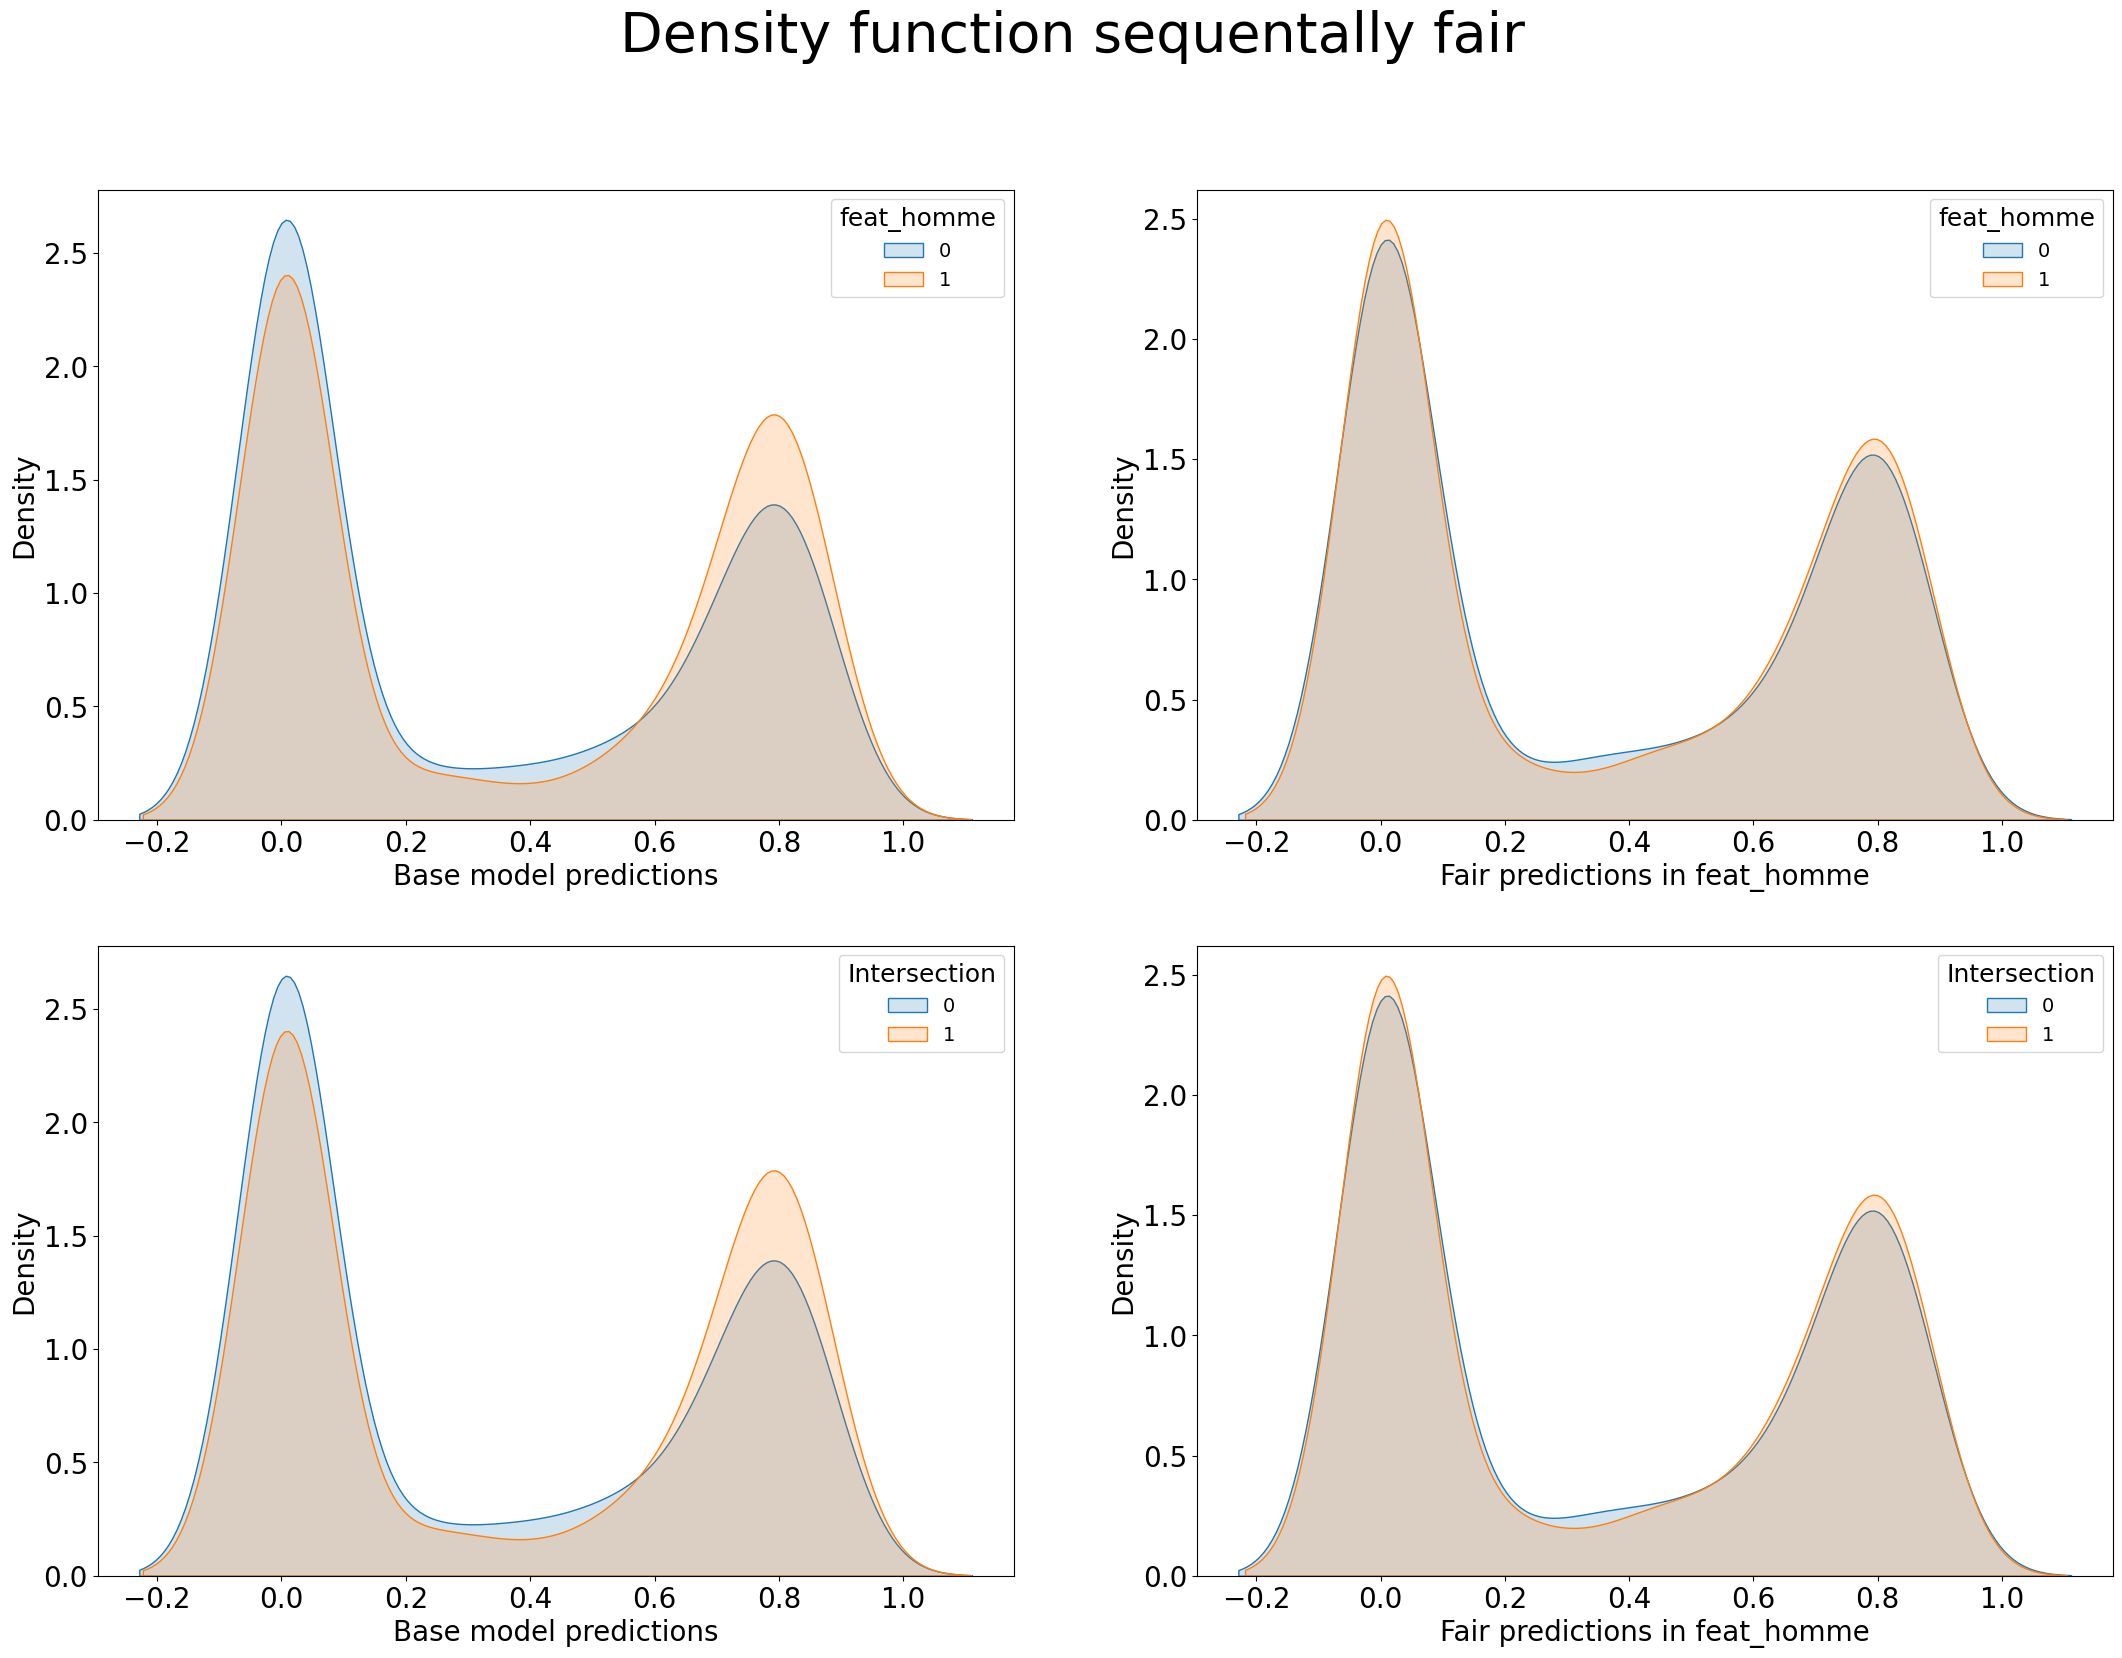

In [ ]:
from equipy.graphs import fair_multiple_arrow_plot,fair_density_plot,fair_waterfall_plot


fair_density_plot(sensitive_features_calib=df_train[["feat_homme"]],
                sensitive_features_test=df_eval[["feat_homme"]], y_calib=y_train_proba, y_test=y_eval_proba, epsilon=[0.2])

Ce premier graphique permet d'évaluer le process de suppression du biais. Puisque la valeur feat_homme est utilisée pour l'entraînement du modèle, il est compréhensible que la mesure de l'inéquité soit élevé. L'ajustement du score selon cette variable permet de supprimer en grande partie ce biais, le résidu correspondant à des variables potentiellement corrélées avec feat_homme ou permettant de l'expliquer.

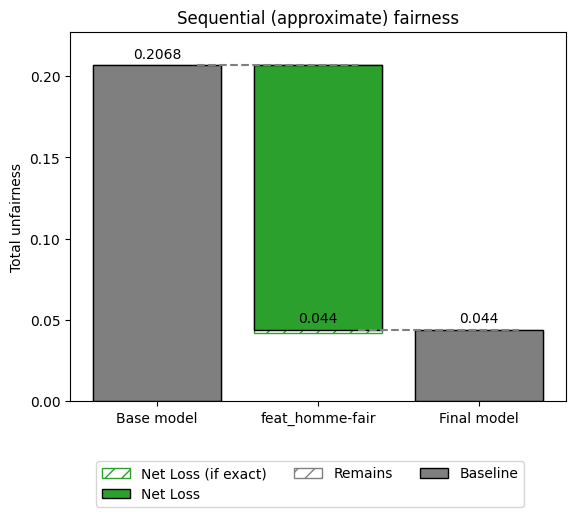

<Axes: title={'center': 'Sequential (approximate) fairness'}, ylabel='Total unfairness'>

In [ ]:
fair_waterfall_plot(sensitive_features_calib=df_train[["feat_homme"]],
                sensitive_features_test=df_eval[["feat_homme"]], y_calib=y_train_proba, y_test=y_eval_proba, epsilon=[0.2])

On évalue enfin les scores (original et ajusté) afin de nous assurer qu'il n'y a pas de perte de performance. En effet, celle-ci est minime.

In [ ]:
def evaluate_predictions(y_true, y_pred, y_proba, model, label=""):
    print(classification_report(y_true, y_pred))

    # Confusion Matrix
    fig, axes = plt.subplots(figsize = (8,3), ncols = 2)
    cm = confusion_matrix(y_true, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=model.classes_)
    disp.plot(ax=axes[0])

    # Confusion Matrix
    axes[0].set_title(f"Confusion Matrix {label}", fontsize=10)

    # ROC-AUC Curve
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                    estimator_name=label)
    display.plot(ax=axes[1])

    axes[1].legend()
    axes[1].plot([0,1], [0,1], ls = ':')
    axes[1].grid()
    axes[1].set_title(f"ROC-AUC Plot {label}", fontsize=10)
    fig.tight_layout()
    plt.show()

              precision    recall  f1-score   support

           0       0.97      0.76      0.85      3761
           1       0.56      0.93      0.70      1239

    accuracy                           0.80      5000
   macro avg       0.76      0.84      0.77      5000
weighted avg       0.87      0.80      0.81      5000



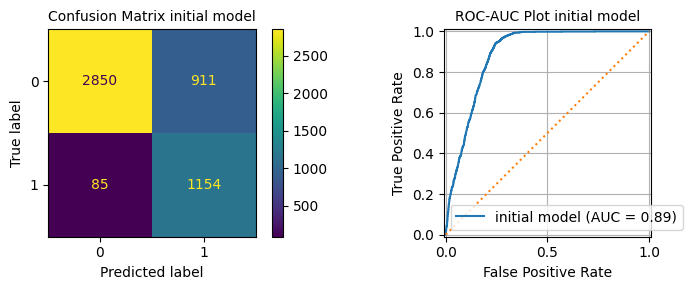

In [ ]:
y_eval_fair_bin=pd.Series(y_eval_fair>model.best_threshold_).astype(int)
y_pred=model.predict(df_eval)
y_proba=model.predict_proba(df_eval)[:, 1]
y_true=df_eval[target]

evaluate_predictions(y_true, y_pred, y_proba, model, label="initial model")

              precision    recall  f1-score   support

           0       0.96      0.76      0.85      3761
           1       0.55      0.90      0.69      1239

    accuracy                           0.80      5000
   macro avg       0.76      0.83      0.77      5000
weighted avg       0.86      0.80      0.81      5000



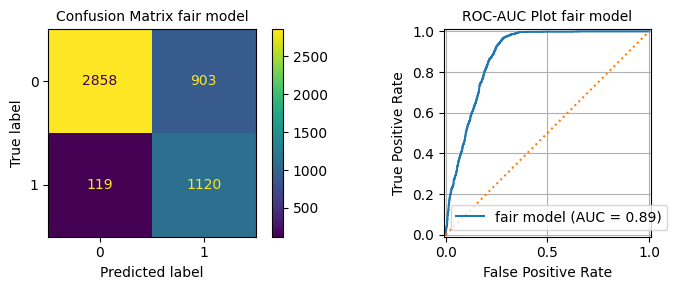

In [ ]:
evaluate_predictions(y_true, y_eval_fair_bin, y_eval_fair, model, label="fair model")